# Basic Imports

In [3]:
#Installing required packages
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 12.0 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=9a602ee8d3184fcb8512e1aad1c34f3f47990aa76635a4e36468f19915375fe4
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [4]:
# Import necessary packages
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

# Loading the Dataframe

In [7]:
#Loading data into df
import pandas as pd

df = pd.read_csv('email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Downsampling

In [8]:
df.groupby('Category').describe()

Message         \
                 count unique   
Category                        
ham               4825   4516   
spam               747    641   
{"mode":"full"       1      1   

                                                                        
                                                              top freq  
Category                                                                
ham                                        Sorry, I'll call later   30  
spam            Please call our customer service representativ...    4  
{"mode":"full"                                    isActive:false}    1

Here we can see that we have only 747 samples of Spam emails whereas we have 4825 sampels of Ham emails. Hence we're going to choose only 747 Ham samples as well.

In [9]:
# Seperate Ham and Spam into 2 different dataframes
df_spam = df[df["Category"] == 'spam']
df_spam.shape

(747, 2)

In [10]:
df_ham = df[df["Category"] == 'ham']
df_ham.shape

(4825, 2)

In [11]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [12]:
df_balanced = pd.concat([df_spam, df_ham_downsampled])
df_balanced.shape

(1494, 2)

In [13]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

# Label Encoding

In [14]:
df_balanced['spam'] = df['Category'].apply(lambda x: 1 if x == 'spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
418,spam,FREE entry into our £250 weekly competition ju...,1
309,spam,TheMob> Check out our newest selection of cont...,1
1888,spam,Urgent! Please call 09061743811 from landline....,1
3750,spam,Dear Voucher Holder 2 claim your 1st class air...,1
1126,spam,For taking part in our mobile survey yesterday...,1
5098,spam,TheMob>Hit the link to get a premium Pink Pant...,1
312,spam,Think ur smart ? Win £200 this week in our wee...,1
194,ham,It will stop on itself. I however suggest she ...,0
4901,spam,"ou are guaranteed the latest Nokia Phone, a 40...",1
3068,ham,Ok. So april. Cant wait,0


# Train - Test Split

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'])

In [16]:
X_train.head()

1097    Dear Subscriber ur draw 4 £100 gift voucher wi...
955             Filthy stories and GIRLS waiting for your
3068                              Ok. So april. Cant wait
622     Good words.... But words may leave u in dismay...
3888    Cab is available.they pick up and drop at door...
Name: Message, dtype: object

# Creating the Model

In [1]:
#Links to the Bert Preprocessor and Encoder
bert_preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [19]:
# Defining the build model function
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(bert_preprocess_url, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert_encoder_url, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1, name ="dropout")(net)
  net = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(net)
  return tf.keras.Model(text_input, net)

In [20]:
# Building the model
classifier_model = build_classifier_model()

In [21]:
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                              

In [22]:
# Defining Metrics for Evaluation
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accurcay'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall')
]

classifier_model.compile(optimizer ='adam',
                         loss ='binary_crossentropy',
                         metrics = METRICS)

# Training the Model

In [ ]:
classifier_model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 588s 16s/step - loss: 0.6484 - accurcay: 0.6062 - precision: 0.6038 - recall: 0.6179
Epoch 2/10
35/35 [==============================] - 577s 16s/step - loss: 0.5246 - accurcay: 0.7902 - precision: 0.7856 - recall: 0.7982
Epoch 3/10
35/35 [==============================] - 576s 16s/step - loss: 0.4568 - accurcay: 0.8357 - precision: 0.8322 - recall: 0.8411
Epoch 4/10
35/35 [==============================] - 573s 16s/step - loss: 0.4111 - accurcay: 0.8670 - precision: 0.8650 - recall: 0.8696
Epoch 5/10
35/35 [==============================] - 568s 16s/step - loss: 0.3732 - accurcay: 0.8830 - precision: 0.8667 - recall: 0.9054
Epoch 6/10
35/35 [==============================] - 568s 16s/step - loss: 0.3524 - accurcay: 0.8911 - precision: 0.8802 - recall: 0.9054
Epoch 7/10
35/35 [==============================] - 567s 16s/step - loss: 0.3369 - accurcay: 0.8884 - precision: 0.8769 - recall: 0.9036
Epoch 8/10
35/35 [=======================

# Evaluating the Model

In [29]:
classifier_model.evaluate(X_test,y_test)

12/12 [==============================] - 194s 16s/step - loss: 0.2833 - accurcay: 0.8984 - precision: 0.8860 - recall: 0.9144


[0.28334537148475647,
 0.8983957171440125,
 0.8860103487968445,
 0.9144384860992432]

In [30]:
# Predicting the labels for Test Dataset
y_predicted = classifier_model.predict(X_test)

# Flattening the 2d array to a 1d array
y_predicted = y_predicted.flatten() 

12/12 [==============================] - 216s 18s/step


In [31]:
# Setting values above 0.5 as 1 (Spam) and below 0.5 as 0 (Non-Spam/Ham)

import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,

In [32]:
# Creating the confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

array([[165,  22],
       [ 16, 171]])

Text(50.722222222222214, 0.5, 'Truth')

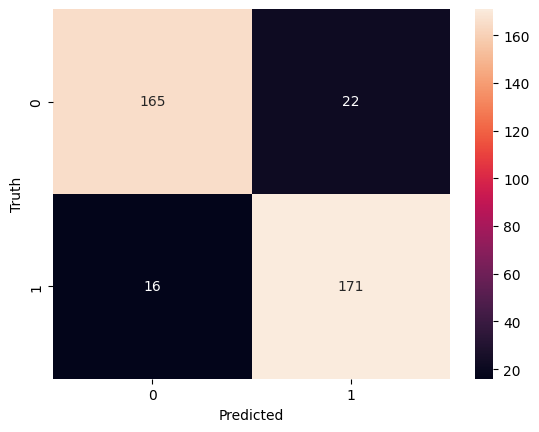

In [34]:
# Graphic representation of the Confusion Matrix
from matplotlib import pyplot as plt
import seaborn as sns

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

Hence we can see that our model has correctly classified 165 Non-Spam emails and 171 Spam emails i.e 336 out of 374 Emails giving an accuracy of 89%.